# 00 은행 4분기 고객 신용 데이터

# 라이브러리

In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats

# pandas 열 개수 max 설정
pd.set_option('display.max_columns', 100)
# pandas 행 개수 max 설정
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

# 함수

In [22]:
# Customer_ID별로 값이 다른 경우 찾는 함수 정의
def find_inconsistent_values(df, column):
    inconsistent = df.groupby('Customer_ID')[column].transform(lambda x: len(x.unique()) > 1)
    inconsistent_df = df[inconsistent]
    return inconsistent_df

# 특수 문자를 제거하고 숫자와 필요한 문자만 남기는 범용 함수 정의
def clean_numeric_column(series):
    def clean_value(value):
        # 정규 표현식을 사용하여 숫자와 소수점만 추출
        numeric_string = re.sub(r'[^\d.-]', '', str(value))
        return float(numeric_string) if numeric_string else np.nan

    return series.apply(clean_value)

# 데이터 불러오기

In [8]:
raw_data = pd.read_excel(r'.\data\Bank Data.xlsx')

In [29]:
df = raw_data.copy()
print("데이터 shape :", df.shape)
print("데이터 컬럼 :", list(df.columns))
df.head(4)

데이터 shape : (50000, 27)
데이터 컬럼 : ['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance']


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.642682,Low_spent_Small_value_payments,186.266702
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,13.27,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.46538,High_spent_Medium_value_payments,361.444004
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,12.27,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.233938,Low_spent_Medium_value_payments,264.675446
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,11.27,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.082511,High_spent_Medium_value_payments,343.826873


# 오탈자 수정 및 결측값 처리

In [34]:
# 결측값 확인된 변수만 출력
df.isnull().sum()[df.isnull().sum() > 0]

Name                       5015
Monthly_Inhand_Salary      7498
Type_of_Loan               5704
Num_of_Delayed_Payment     3498
Num_Credit_Inquiries       1035
Credit_History_Age         4470
Amount_invested_monthly    2271
Monthly_Balance             562
dtype: int64

## 1)인구통계학적 변수

### 1. Name 처리

In [25]:
# Name : null 값 존재 5015 개
# 같은 Customer_ID를 가진 행에서 이름 가져오기, ffill, bfill 사용, 결측값 채우기
df['Name'] = df.groupby('Customer_ID')['Name'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill')) # 결측값 채운 후에 1명의 고객은 채워지지 않음. -> 해당 고객의 이름이 없음

### 2. Age 처리

In [26]:
# 숫자와 음수 부호만 남기고 나머지 문자 제거
df['Age'] = df['Age'].apply(lambda x: ''.join(filter(lambda c: c.isdigit() or c == '-', str(x))))

# 숫자형으로 변환, 변환 불가한 값은 NaN 처리
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# 0보다 작거나 같거나 100보다 큰 값은 NaN 처리
df['Age'] = df['Age'].apply(lambda x: x if 0 <= x <= 100 else np.nan)

# Month 순서 지정
month_order = ['September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Customer_ID별로 Month 순서에 따라 Age 값을 채우는 함수 정의
def fill_age_with_recent(series):
    # 가장 최근 값으로 채우기
    return series.ffill().bfill()

# Customer_ID별로 Age의 최빈값으로 변경
df['Age'] = df.groupby('Customer_ID')['Age'].transform(fill_age_with_recent) # 나중에 고객 별 통합할 때 가장 최근값으로 들고오기

### 3. Occupation 처리

In [27]:
# Customer_ID 별로 Occupation 은 같아야 한다.
# Customer_ID별 Occupation의 최빈값으로 통일하기
def fill_with_mode(series):
    mode = series.mode()
    if not mode.empty:
        return mode[0]
    else:
        return series.value_counts().idxmax()  # 최빈값이 없는 경우 가장 많이 등장한 값으로 대체

# Customer_ID별로 Occupation의 최빈값으로 변경
df['Occupation'] = df.groupby('Customer_ID')['Occupation'].transform(fill_with_mode)

# Occupation이 오직 특수문자로만 되어 있는 경우 '무직'으로 변경
df['Occupation'] = df['Occupation'].apply(lambda x: 'unemployment' if not any(c.isalnum() for c in x) else x)

# 확인
# df['Occupation'].value_counts()

## 2)금융 정보 변수

### 1~2. Annual Income, Monthly_Inhand_Salary 처리

In [44]:
# Customer_ID별 Annual_Income의 최빈값으로 통일하기
def fill_with_mode(series):
    mode = series.mode()
    if not mode.empty:
        return mode[0]
    else:
        return series.mean()  # 최빈값이 없는 경우 평균값으로 대체

# Customer_ID별로 Annual_Income의 최빈값으로 변경
df['Annual_Income'] = df.groupby('Customer_ID')['Annual_Income'].transform(fill_with_mode)

In [45]:
df['Monthly_Inhand_Salary'] = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(fill_with_mode)

### 3. Outstanding_Debt : 미결제 부채
- 현재까지 결제되지 않은 부채의 총액
- 같은 Customer_ID 라면 부채의 총액이 변동된 경우가 없음.

In [42]:
# 숫자와 소수점만 남기고 나머지 문자 제거 및 비어 있는 값 처리 함수 정의
def clean_outstanding_debt(value):
    # 정규 표현식을 사용하여 숫자와 소수점만 추출
    numeric_string = re.sub(r'[^\d.]', '', str(value))
    return float(numeric_string) if numeric_string else np.nan

# 적용
df['Outstanding_Debt'] = df['Outstanding_Debt'].apply(clean_outstanding_debt)

In [43]:
# Customer_ID별로 Outstanding_Debt 값이 다른 경우 찾기
inconsistent_debt = df.groupby('Customer_ID')['Outstanding_Debt'].transform(lambda x: len(x.unique()) > 1)
inconsistent_debt_df = df[inconsistent_debt]
inconsistent_debt_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance


### 4. Credit_Utilization_Ratio : 신용 이용 비율
- 단위 : %
- float 자료형
- 사용 중인 회전 신용금액을 총 이용 가능한 신용으로 나눈 비율
- 현재 부채를 얼마나 잘 관리하고 있는지 판단하는 데 도움이 된다.
- 신용 이용률이 낮을 수록 신용등급에 더 좋고, 신용위험도가 낮은 것으로 평가된다. 따라서 신용 이용률이 낮은 것이 더 바람직하다. 30%이하가 이상적

{'whiskers': [<matplotlib.lines.Line2D at 0x22388cd20a0>,
 'caps': [<matplotlib.lines.Line2D at 0x223888d9dc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22388cd2400>],
 'medians': [<matplotlib.lines.Line2D at 0x22387637dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22388cd2d60>],
 'means': []}

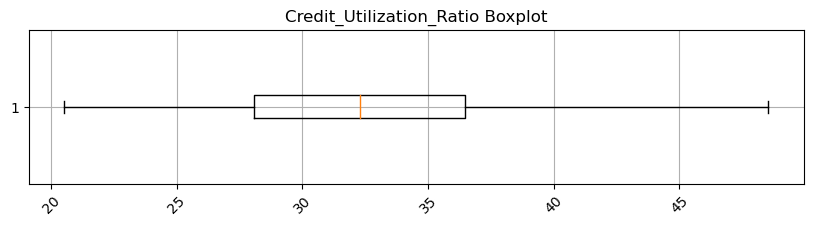

In [44]:
# Credit_Utilization_Ratio변수 boxplot으로 확인, 세로로
plt.figure(figsize=(10, 2))
plt.xticks(rotation=45)
plt.grid()
plt.title('Credit_Utilization_Ratio Boxplot')
plt.boxplot(df['Credit_Utilization_Ratio'], vert=False)

### 4. Monthly_Balance
- 월간 잔액 : 월말 기준 계좌의 잔액
- float 자료형
- 결측치 562 개
- 들쭉날쭉한 경우가 있어서 전달, 혹은 이후 달의 값으로 채워넣기가 애매함.

In [45]:
df['Monthly_Balance'] = clean_numeric_column(df['Monthly_Balance'])

In [46]:
# 결측값 제거
df = df.dropna(subset=['Monthly_Balance'])

## 3)거래 변수

### 1. Num_Bank_Accounts
- 보유한 은행 계좌 수.
- 결측치 없음. 
- 9~12월까지 은행 계좌수가 -1 이 찍히는 경우가 있음.
- **은행 계좌수와 카드 수는 변동이 가능하기 때문에 threshold 를 줘서 너무 큰 변화가 있는 것이 아니라면 허용**

In [47]:
# Customer_ID별 최빈값으로 통일하되, 너무 이상한 값이 아닌 경우 그대로 두는 함수 정의
def fill_with_mode(series, threshold=5):
    mode = series.mode()
    if not mode.empty:
        mode_value = mode[0]
        # 차이가 threshold보다 큰 경우에만 변경
        return series.apply(lambda x: mode_value if abs(x - mode_value) > threshold else x)
    else:
        return series

In [48]:
# Customer_ID별로 Num_Bank_Accounts 값을 처리
df['Num_Bank_Accounts'] = df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(fill_with_mode)

# Num_Bank_Accounts가 음수인 경우 제거
df = df[df['Num_Bank_Accounts'] >= 0]

### 2. Num_Credit_Card 처리

In [49]:
# Customer_ID 별로 New_Credit_Card 어떻게 구성되어 있는지 확인
find_inconsistent_values(df, 'Num_Credit_Card')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
116,0x1766,CUS_0xb681,September,Sarahb,38.0,904-88-7361,Manager,39641.540,3007.461667,10,211,25,6,"Auto Loan, Student Loan, Payday Loan, Payday L...",61,13,1.54,8.0,Bad,2258.73,32.775937,9 Years and 4 Months,Yes,172.382527,159.881232,Low_spent_Small_value_payments,258.482407
117,0x1767,CUS_0xb681,October,Sarahb,38.0,904-88-7361,Manager,39641.540,3007.461667,10,8,25,6,"Auto Loan, Student Loan, Payday Loan, Payday L...",61,19,1.54,8.0,Bad,2258.73,37.554247,NaN,Yes,50770.000000,254.317793,Low_spent_Large_value_payments,144.045846
118,0x1768,CUS_0xb681,November,Sarahb,38.0,904-88-7361,Manager,39641.540,3007.461667,10,8,25,6,"Auto Loan, Student Loan, Payday Loan, Payday L...",59,14,1.54,8.0,_,2258.73,37.691520,9 Years and 6 Months,NM,172.382527,115.706797,High_spent_Medium_value_payments,262.656842
119,0x1769,CUS_0xb681,December,Sarahb,38.0,904-88-7361,Manager,39641.540,3007.461667,10,8,25,6,"Auto Loan, Student Loan, Payday Loan, Payday L...",60,2077,1.54,8.0,Bad,2258.73,24.749141,9 Years and 7 Months,Yes,172.382527,138.195361,Low_spent_Small_value_payments,280.168279
144,0x17ba,CUS_0x4080,September,ra Alperx,16.0,995-37-8920,Mechanic,29469.980,2227.831667,7,7,24,5,"Personal Loan, Credit-Builder Loan, Debt Conso...",48,21,26.94,12.0,Bad,3421.66,25.421302,13 Years and 10 Months,Yes,69.685459,167.271439,Low_spent_Large_value_payments,255.826269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49887,0x25ea1,CUS_0xc345,December,Jeb Blountf,24.0,176-40-0757,Architect,60015.320,5121.276667,7,4,14,7,"Mortgage Loan, Mortgage Loan, Credit-Builder L...",8,5,10.47,7.0,Standard,1095.15,29.553506,16 Years and 1 Months,Yes,187.008683,89.915409,High_spent_Medium_value_payments,485.203575
49920,0x25f0a,CUS_0x944e,September,Vlastelicax,24.0,815-15-2261,Architect,11834.645,688.220417,5,7,10,2,"Credit-Builder Loan, and Payday Loan",30,13,15.62,10.0,Standard,1095.90,27.173830,13 Years and 11 Months,Yes,11.089575,17.342016,High_spent_Medium_value_payments,290.390451
49921,0x25f0b,CUS_0x944e,October,Vlastelicax,24.0,815-15-2261,Architect,11834.645,688.220417,5,7,10,2,"Credit-Builder Loan, and Payday Loan",26,14,15.62,10.0,Standard,1095.90,28.018200,14 Years and 0 Months,Yes,11.089575,NaN,Low_spent_Small_value_payments,274.476174
49922,0x25f0c,CUS_0x944e,November,Vlastelicax,24.0,#F%$D@*&8,Architect,11834.645,688.220417,5,7,10,2,"Credit-Builder Loan, and Payday Loan",27,12,15.62,10.0,Standard,1095.90,22.922525,14 Years and 1 Months,Yes,11.089575,85.27421,Low_spent_Small_value_payments,262.458257


In [50]:
df['Num_Credit_Card'] = df.groupby('Customer_ID')['Num_Credit_Card'].transform(fill_with_mode) # 최빈값으로 대체

### 3. Total_EMI_per_month
- 고객이 매월 지불하는 EMI(원리금 균등 상환액 ; 할부금) 의 총합
- 대출 수가 늘어나지 않았는데 (할부금)이 늘어난 경우는 어떤거지 ?
- 대출이 늘어나거나, 대출 외의 상환금이 늘어날 수도 있기 때문에 임의의 threshold(1000$) 로 설정해서 이 외의 값들은 최빈값으로 대체

In [51]:
# Customer_ID별로 Total_EMI_per_month 값을 처리 (threshold=1000)
df['Total_EMI_per_month'] = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(lambda x: fill_with_mode(x, threshold=1000))

In [52]:
find_inconsistent_values(df, 'Total_EMI_per_month')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
144,0x17ba,CUS_0x4080,September,ra Alperx,16.0,995-37-8920,Mechanic,29469.98,2227.831667,7,7,24,5,"Personal Loan, Credit-Builder Loan, Debt Conso...",48,21,26.94,12.0,Bad,3421.66,25.421302,13 Years and 10 Months,Yes,69.685459,167.271439,Low_spent_Large_value_payments,255.826269
145,0x17bb,CUS_0x4080,October,ra Alperx,16.0,995-37-8920,Mechanic,29469.98,2227.831667,7,7,24,5,"Personal Loan, Credit-Builder Loan, Debt Conso...",49,21,26.94,12.0,Bad,3421.66,32.592076,13 Years and 11 Months,Yes,69.685459,31.602605,High_spent_Large_value_payments,361.495103
146,0x17bc,CUS_0x4080,November,ra Alperx,17.0,995-37-8920,Mechanic,29469.98,2227.831667,7,7,24,5,"Personal Loan, Credit-Builder Loan, Debt Conso...",53,21,26.94,12.0,_,3421.66,32.540660,14 Years and 0 Months,Yes,268.789214,130.527359,High_spent_Small_value_payments,282.570349
147,0x17bd,CUS_0x4080,December,ra Alperx,17.0,995-37-8920,Mechanic,29469.98,2227.831667,7,7,24,5,"Personal Loan, Credit-Builder Loan, Debt Conso...",53,21,26.94,12.0,Bad,3421.66,33.988956,14 Years and 1 Months,Yes,268.789214,125.237332,Low_spent_Small_value_payments,317.860376
328,0x19e2,CUS_0xe2c,September,Andreasc,39.0,755-51-7133,Journalist,31021.24,2660.636339,7,7,11,4,"Auto Loan, Auto Loan, Auto Loan, and Personal ...",16,18,11.21,7.0,Standard,852.81,29.022727,33 Years and 6 Months,No,90.759178,77.125087,High_spent_Medium_value_payments,357.726068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49839,0x25e11,CUS_0xbd8f,December,Amena Bakrb,32.0,344-21-3701,Lawyer,107911.60,9168.633333,3,3,17,2,"Home Equity Loan, and Home Equity Loan",21,17,11.31,5.0,Standard,1086.96,28.243880,18 Years and 8 Months,No,787.450658,97.254804,High_spent_Large_value_payments,948.982541
49940,0x25f46,CUS_0x47fa,September,Yantoultra Nguif,32.0,291-51-7240,Mechanic,64511.34,5440.945000,7,3,15,0,NaN,7,10,18.57,2.0,Standard,330.60,38.297084,23 Years and 6 Months,Yes,0.000000,213.328095,High_spent_Medium_value_payments,580.766405
49941,0x25f47,CUS_0x47fa,October,Yantoultra Nguif,32.0,291-51-7240,Mechanic,64511.34,5440.945000,7,3,15,0,NaN,7,8,18.57,7.0,Standard,330.60,29.525937,23 Years and 7 Months,Yes,0.000000,104.922311,High_spent_Large_value_payments,679.172189
49942,0x25f48,CUS_0x47fa,November,Yantoultra Nguif,32.0,291-51-7240,Mechanic,64511.34,5440.945000,7,3,15,0_,NaN,9,8,18.57,7.0,Standard,330.60,31.083920,NaN,Yes,0.000000,__10000__,High_spent_Large_value_payments,658.261080


### 4. Amount_invested_monthly
- 월별 투자 금액
- 결측값 2248개 -> 0 으로 대체
- 이상치, 보수적으로 접근 (제거 x)

In [53]:
# 숫자만 남기기
df['Amount_invested_monthly'] = clean_numeric_column(df['Amount_invested_monthly'])  

In [54]:
# 결측치 0으로 대체
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].fillna(0)

### 5. Num_of_Loan
- 대출 개수
- Type_of_Loan(대출 종류) 와 동일해야 한다.

In [55]:
# 숫자만 남기기
df['Num_of_Loan'] = clean_numeric_column(df['Num_of_Loan']) 

In [56]:
#  Num_of_Loan 변수를 Type_of_Loan 변수에 따라 변환하는 함수 정의
def update_num_of_loan(row):
    if pd.isna(row['Type_of_Loan']) or row['Type_of_Loan'].strip() == '':
        return 0
    else:
        return len(row['Type_of_Loan'].split(','))

# Num_of_Loan 업데이트
df['Num_of_Loan'] = df.apply(update_num_of_loan, axis=1)

### 6. Type_of_Loan

In [57]:
# Type_of_Loan 변수의 값이 다른 경우 찾기
inconsistent_loans = find_inconsistent_values(df, 'Type_of_Loan')
df[df['Type_of_Loan'].isna()].head(2)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
16,0x163a,CUS_0x1cdb,September,Deepaa,22.0,615-06-7821,Developer,35547.71,2853.309167,7,5,5,0,NaN,5,15,2.58,4.0,_,943.86,34.729842,31 Years and 4 Months,Yes,0.0,59.366058,High_spent_Medium_value_payments,475.964859
17,0x163b,CUS_0x1cdb,October,Deepaa,22.0,#F%$D@*&8,Developer,35547.71,2853.309167,7,5,5,0,NaN,5,18,2.58,5.0,Standard,943.86,31.652351,31 Years and 5 Months,Yes,0.0,113.452656,High_spent_Medium_value_payments,421.878260


In [58]:
# Type_of_Loan 변수의 결측값을 'None'으로 대체
df['Type_of_Loan'] = df['Type_of_Loan'].fillna('None')

In [59]:
# Type_of_Loan 열을 , 단위로 분리하여 개별 대출 종류를 추출하는 함수 정의
def split_type_of_loan(loan_types):
    if pd.isna(loan_types) or loan_types.strip() == '':
        return []
    else:
        # , 단위로 분리하고 각 대출 종류의 양쪽 공백을 제거하며 'and'를 제거
        return [loan.strip().replace('and ', '').replace('And ', '') for loan in loan_types.split(',')]

# Type_of_Loan 열을 분리하여 리스트로 변환
df['Type_of_Loan_List'] = df['Type_of_Loan'].apply(split_type_of_loan)

# One-Hot Encoding을 위해 MultiLabelBinarizer 사용
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
loan_encoded = mlb.fit_transform(df['Type_of_Loan_List'])

# One-Hot Encoded DataFrame 생성
loan_encoded_df = pd.DataFrame(loan_encoded, columns=mlb.classes_, index=df.index)

# 원본 DataFrame과 One-Hot Encoded DataFrame 병합
df = df.drop('Type_of_Loan_List', axis=1).join(loan_encoded_df)

## 신용 변수

### 1. Interest_Rate ; 이자율
- 이자율 30% 이상은 고금리(약 3000명 정도 있음.), 카테고리 변수 생성 가능
- 저금리, 중금리, 고금리
- 4개월 내에 이자율 변동하는 경우가 거의 없으므로 이상치 -> 그룹별 최빈값으로 대체

In [60]:
# 보통 이자율 : 30% 미만
# 고금리 이자율 : 30% 이상
# Customer_ID 확인 결과 4개월 안에 이자율이 변동하는 경우는 거의 없음
# Customer_ID별 Annual_Income의 최빈값으로 통일하기
def fill_with_mode_min(series):
    mode = series.mode()
    if not mode.empty:
        return mode[0]
    else:
        return series.min()  # 최빈값이 없는 경우 최소값으로 대체

# 최빈값 혹은 최소값으로 통일
df['Interest_Rate'] = df.groupby('Customer_ID')['Interest_Rate'].transform(fill_with_mode_min)

# 이자율 100% 넘어가면 제거
df = df[df['Interest_Rate'] <= 100]

# 데이터 shape 확인
print("데이터 shape :", df.shape)

데이터 shape : (49420, 37)


### 2. Delay_from_due_date ; 연체 기간
- 금융 기관에서 선정한 연체 기간 별 고객 카테고리가 있음. ; 60일 이상 : 부도 ? 
- 금융 기관의 기준에 따라서 카테고리 변수 생성 가능
- 연체를 발생시키는 고객들의 특성을 파악해서 앞으로 이러한 특성을 가지는 고객은 대출 x
- 단위 : 일 단위
- 67 까지는 허용범위라고 판단

In [61]:
print("num NA :", df['Delay_from_due_date'].isna().sum())
print(df['Delay_from_due_date'].describe()) # max : 67인 것을 보니 2개월 이상 지연된 경우가 있음, 단위 : 일

# df = df[df['Delay_from_due_date'] >= 0] # 나중에 고객을 하나로 합칠 때, 평균값 혹은 중앙값 사용 고려
# 0 보다는 커야함.
# 0 보다 작은 값은 0으로 대체
df['Delay_from_due_date'] = df['Delay_from_due_date'].apply(lambda x: max(0, x))

# 데이터 shape 확인
print("데이터 shape :", df.shape)

num NA : 0
count    49420.000000
mean        21.011837
std         14.843195
min         -5.000000
25%         10.000000
50%         18.000000
75%         28.000000
max         67.000000
Name: Delay_from_due_date, dtype: float64
데이터 shape : (49420, 37)


### 3. Num_of_Delayed_Payment ; 연체 횟수
- 0보다 작은 값 있을 수 없음.
- 값에 변동성이 있어서 이상치를 제거

In [62]:
# 숫자와 음수 부호만 남기고 나머지 문자 제거
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].apply(lambda x: ''.join(filter(lambda c: c.isdigit() or c == '-', str(x))))

# 빈 값을 NaN으로 변환
df['Num_of_Delayed_Payment'].replace('', np.nan, inplace=True)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].astype(float)

In [ ]:
# IQR을 활용한 이상치 제거 함수 정의
def remove_outliers_iqr(df, weight, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = 0
    upper_bound = Q3 + weight * IQR
    
    print(lower_bound, upper_bound)
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# IQR 을 활용해 이상치 제거 (0, 31.5)
df = remove_outliers_iqr(df, 1.5, 'Num_of_Delayed_Payment')

0 31.5


### 4. Changed_Credit_Limit : 신용 한도 변경 여부
- 값에 변동성이 잇어서 이상치는 제거 (0보다 작은 경우;음수)

In [ ]:
import re

# 특수문자 포함되어 있는 경우 제거
# 숫자만 남기고 특수문자 제거 및 비어 있는 값 처리 함수 정의
def clean_credit_limit(value):
    if isinstance(value, str) and value.strip() == '':
        return np.nan
    else:
        # 정규 표현식을 사용하여 숫자만 추출
        numeric_string = re.sub(r'[^\d.-]', '', str(value))
        return float(numeric_string) if numeric_string else np.nan

# 적용
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].apply(clean_credit_limit)

# 0보다 큰 값만 남기기
df = df[df['Changed_Credit_Limit'] > 0]

### 5. Num_Credit_Inquiries : 신용 조회 수
- 값에 변동성이 있어서 이상치를 제거
- 다른 통계값으로 대체하는 것이 리스크가 있다고 판단

In [ ]:
df = remove_outliers_iqr(df, 2, 'Num_Credit_Inquiries')

0 22.0


### 6. Credit_Mix : 신용 구성
- 3 class
- '_' 바 형태로 제시되는 경우가 있음, 확인해보니 같은 Customer_ID 의 다른 값들은 동일한 값으로 들어가 있음.

In [ ]:
# 같은 Customer_ID 내의 최빈값으로 대체하는 함수 정의
def replace_underscore_with_mode(group):
    mode = group[group != '_'].mode()
    if not mode.empty:
        mode_value = mode[0]
        return group.apply(lambda x: mode_value if x == '_' else x)
    else:
        return group

# 적용
df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].transform(replace_underscore_with_mode)

# 이렇게 처리 후에도 언더바가 남아있는 경우 제거
df = df[df['Credit_Mix'] != '_']

### 7. Credit_History_Age
- '22 Years and 10 Months' 형태로 되어 있음. 개월 수로 변경 (수치형) 혹은 년도만 살리기

In [ ]:
# 결측값이 아닐 경우에만 
df['Credit_History_Age'] = df['Credit_History_Age'].apply(lambda x : x.split(' ')[0] if x is not np.nan else x)

# 결측값일 경우 같은 Customer_ID 내에서 최빈값으로 대체
# 최빈값이 없을 경우 제거
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.dropna())

## 5) 결제 행동 변수

### 1.Payment_of_Min_Amount : 최소 금액 지불 여부
- yes, no, nm 
- nm이 상당히 많아서 오탈자라기 보다는 특정 의미를 지니는 것 같음
- nm 추정 : Not Measured : 측정안됨.
- 같은 고객 데이터 중 다른 값 선택

In [ ]:
# Customer_ID별로 Payment_of_Min_Amount 값이 다른 경우 찾기
# inconsistent = find_inconsistent_values(df, 'Payment_of_Min_Amount')
# inconsistent[['Customer_ID', 'Payment_of_Min_Amount']].head(30)
# 'NM'을 NaN으로 변경
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('NM', np.nan)

# Customer_ID 별로 최빈값으로 채우기 위한 함수 정의
def fill_with_mode(group):
    mode = group.mode()
    if not mode.empty:
        return group.fillna(mode[0])
    else:
        return group.fillna('No')  # 최빈값이 없는 경우 'No'로 채우기

# Customer_ID 별로 Payment_of_Min_Amount의 결측값을 최빈값으로 채우기
df['Payment_of_Min_Amount'] = df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(fill_with_mode)

#
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('no', 'No')

### 2. Payment_Behaviour
- 결제 행동 데이터

In [ ]:
df = df[df['Payment_Behaviour'] != '!@9#%8'].reset_index(drop=True)

In [819]:
# drop na 
df = df.dropna()
df.to_csv(r'.\data\Bank Data Preprocessed.csv', index=False)

In [778]:
# df = pd.read_csv(r'.\data\Bank Data Preprocessed.csv')

# 고객 세분화를 위한 고객 통합

In [820]:
# 필요 없는 변수 목록
columns_to_drop = ['ID', 'SSN', 'Name', 'Month']

# 필요 없는 변수 제거
df = df.drop(columns=columns_to_drop)

In [752]:
# Customer_ID 별 집계
# 최빈값 : Occupation, Annual_Income, Monthly_Inhand_Salary, Type_of_Loan, Credit_Mix, Payment_of_Min_Amount, Payment_Behaviour, 
# 평균값 : Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Delay_from_due_date, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Outstanding_Debt, Credit_Utilization_Ratio, Total_EMI_per_month, Amount_invested_monthly, Monthly_Balance,  
# 최대값 : Age, Credit_History_Age, 'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'None', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'

In [822]:
# 집계 방법에 따른 그룹화 및 통합된 데이터프레임 생성
grouped_df = df.groupby('Customer_ID').agg({
    'Occupation': lambda x: x.mode()[0],
    'Annual_Income': lambda x: x.mode()[0],
    'Monthly_Inhand_Salary': lambda x: x.mode()[0],
    'Credit_Mix': lambda x: x.mode()[0],
    'Payment_of_Min_Amount': lambda x: x.mode()[0],
    'Payment_Behaviour': lambda x: x.mode()[0],
    'Num_Bank_Accounts': 'mean',
    'Num_Credit_Card': 'mean',
    'Interest_Rate': 'mean',
    'Num_of_Loan': 'mean',
    'Delay_from_due_date': 'mean',
    'Num_of_Delayed_Payment': 'mean',
    'Changed_Credit_Limit': 'mean',
    'Num_Credit_Inquiries': 'mean',
    'Outstanding_Debt': 'mean',
    'Credit_Utilization_Ratio': 'mean',
    'Total_EMI_per_month': 'mean',
    'Amount_invested_monthly': 'mean',
    'Monthly_Balance': 'mean',
    'Age': 'max',
    'Credit_History_Age': 'max',
    'Auto Loan': 'max',
    'Credit-Builder Loan': 'max',
    'Debt Consolidation Loan': 'max',
    'Home Equity Loan': 'max',
    'Mortgage Loan': 'max',
    'None': 'max',
    'Not Specified': 'max',
    'Payday Loan': 'max',
    'Personal Loan': 'max',
    'Student Loan': 'max'
}).reset_index()

In [824]:
grouped_df.to_csv(r'.\data\Bank Data Grouped.csv', index=False)

# 문제
- 00 은행 4분기 고객들의 특성을 파악하여, 향후 어떠한 전략을 세우는 것이 유리할지 고민
- 9, 10, 11, 12 월 의 데이터를 각각 파악해서 차이를 구하고 만약 연체율이 올라간다면 왜 그런지 가설을 설정하고, 어떠한 대응 전략을 펼칠 수 있을지 생각
- 대출 상품 별로 고객이 어떻게 분포하고 있는지 확인
- 은행의 리스크를 줄이고 대출을 해줄수 있는 고객들을 선별
- 평균적으로 신용 등급이 안좋은 고객 보유율을 다른 은행들과 비교하여 우리 은행은 현재 이러한 상태이고, 이들을 관리하기 위해 어떤 방안을 마련할 수 있을지 고민

In [4]:
import pandas as pd 

# 분석 개요 -> 데이터 설명 -> 전처리 -> 통계 분석 -> 시각화
# 연체 고객 중에서도 개입이 필요한 고객, 그 이유
df_grouped = pd.read_csv(r'.\data\Bank Data Grouped.csv')
# ================================================================================
# 추가적인 데이터 전처리
# ---<Monthly Balance 변수 정제>---
# 음수 값 개수 확인 및 제거
negative_balance = df_grouped[df_grouped['Monthly_Balance'] < 0]
print("음수 값 개수 :", negative_balance.shape[0])

# 음수 값 제거
df_grouped = df_grouped[df_grouped['Monthly_Balance'] >= 0]

# ---<Interest Rate 변수 정제>---
# 100 이상인 값 확인
high_interest_rate = df_grouped[df_grouped['Interest_Rate'] >= 100]
print("100 이상인 값 개수 :", high_interest_rate.shape[0])

# 100 이상인 값 제거
df_grouped = df_grouped[df_grouped['Interest_Rate'] < 100]

음수 값 개수 : 6
100 이상인 값 개수 : 1


In [5]:
df_grouped.shape

(12265, 32)

## 연속형 변수 시각화

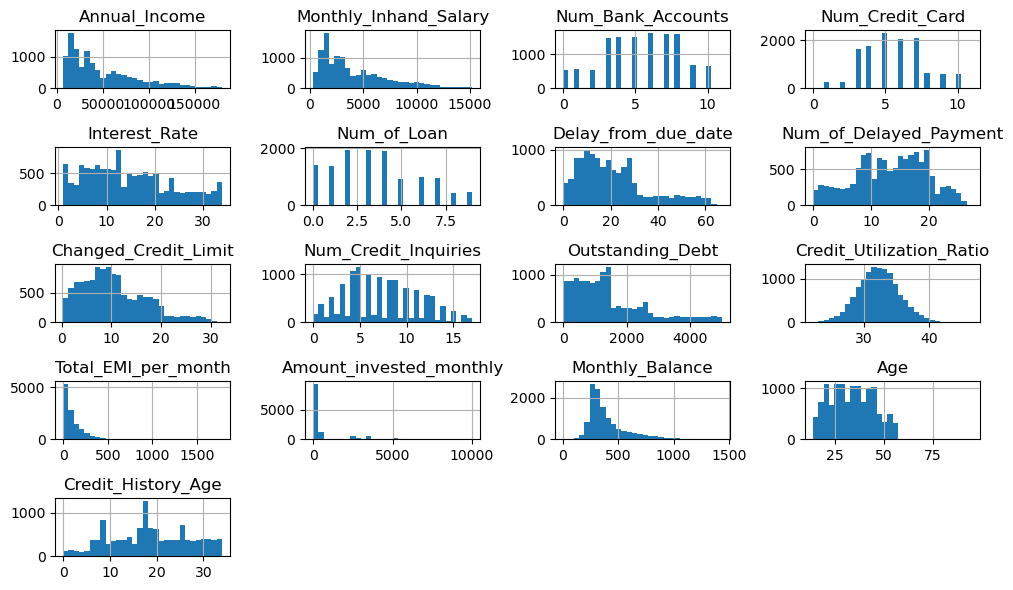

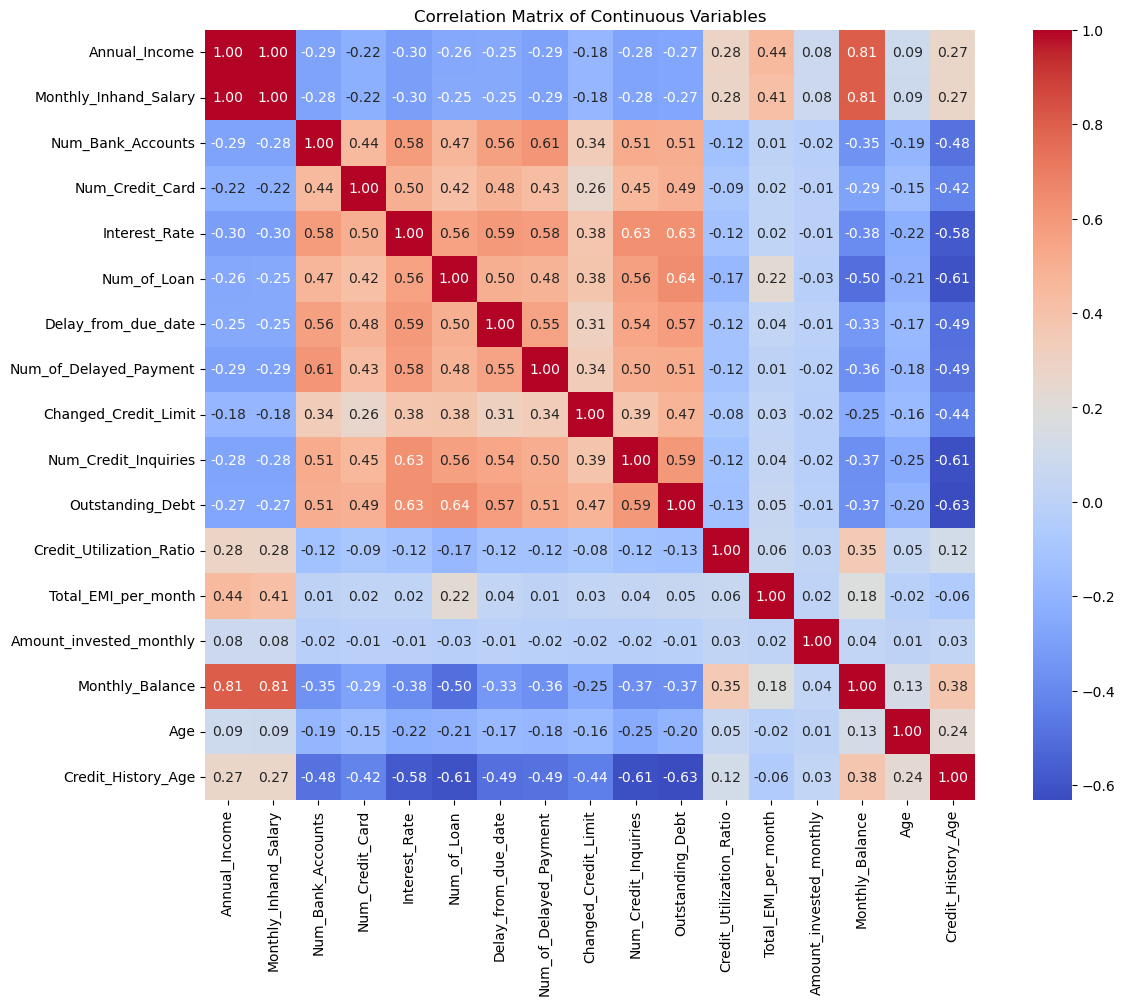

In [154]:
# 연속형 변수 목록
continuous_vars = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 
    'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 
    'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 
    'Monthly_Balance', 'Age', 'Credit_History_Age'
]

# 연속형 변수들의 히스토그램
df_grouped[continuous_vars].hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

# 연속형 변수들 간의 상관행렬
corr_matrix = df_grouped[continuous_vars].corr()

# 상관행렬 히트맵 시각화
# 대각선을 기준으로 대칭인 행렬이므로, 대각선을 기준으로 한 쪽만 표시
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square = True)
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

In [161]:
# Credit Mix 카테고리 별로 연속형 변수들의 분포 차이를 검정하기 위해 ANOVA 테스트 수행
anova_results = {}
for var in continuous_vars:
    groups = [df_grouped[df_grouped['Credit_Mix'] == category][var].dropna() for category in df_grouped['Credit_Mix'].unique()]
    f_val, p_val = stats.f_oneway(*groups)
    anova_results[var] = {'F-value': f_val, 'p-value': p_val}

# 결과를 데이터프레임으로 정리
anova_results_df = pd.DataFrame(anova_results).T
anova_results_df = anova_results_df.sort_values(by='p-value')

anova_results_df

# 대출 가능 고객 
# 대출 불가능 고객 
# 관리 고객 

# 연간 소득, 월 잔액, 미결제 부채
# 

,F-value,p-value
Annual_Income,838.979697,0.000000e+00
Monthly_Balance,1479.224767,0.000000e+00
Outstanding_Debt,8959.784661,0.000000e+00
Num_Credit_Inquiries,4857.993681,0.000000e+00
Num_of_Delayed_Payment,8787.136709,0.000000e+00
Delay_from_due_date,6263.505705,0.000000e+00
Changed_Credit_Limit,1567.679286,0.000000e+00
Interest_Rate,8055.682543,0.000000e+00
Num_Credit_Card,2808.884552,0.000000e+00
Num_Bank_Accounts,6737.445711,0.000000e+00


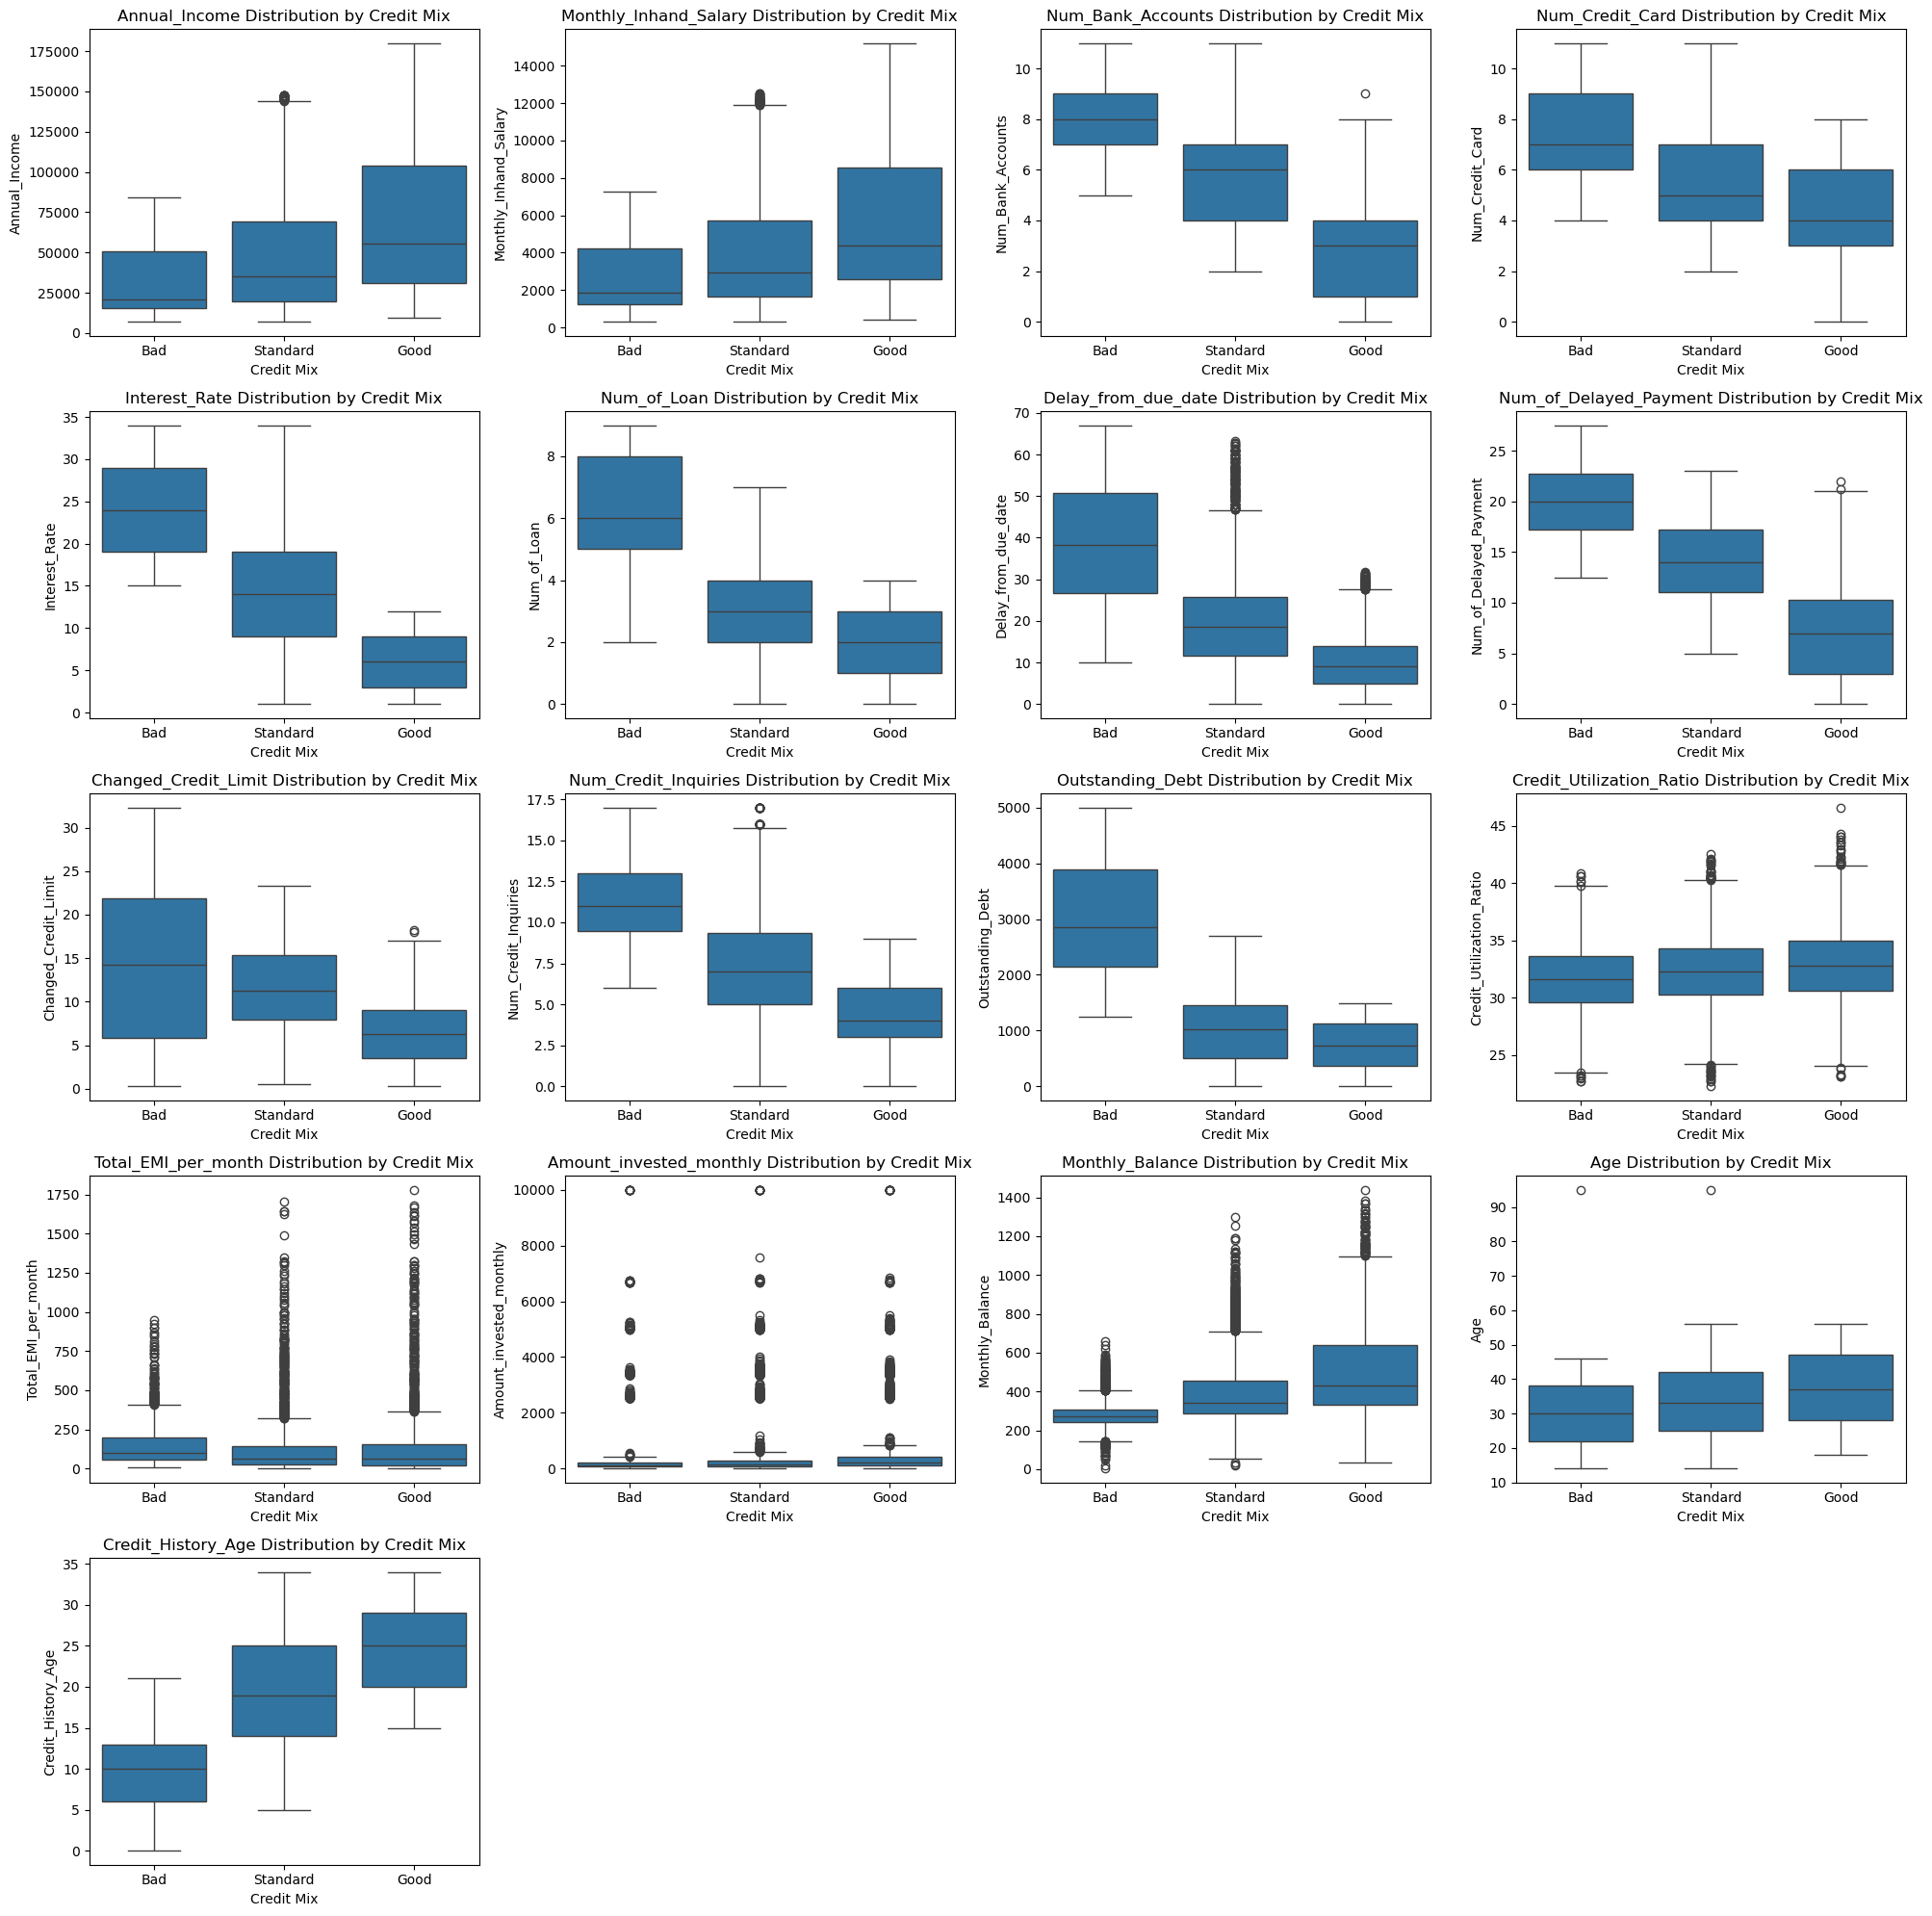

In [163]:
# 연체 고객 중에서도 개입이 필요한 고객, 그 이유
# 연체 고객 중에서도 개입이 필요한 고객을 찾기 위해 다양한 변수를 고려
# Credit Mix 기준으로 연속형 변수의 분포 시각화
plt.figure(figsize=(20, 20))

for i, var in enumerate(continuous_vars, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x='Credit_Mix', y=var, data=df_grouped)
    plt.title(f'{var} Distribution by Credit Mix')
    plt.xlabel('Credit Mix')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

## 신용 등급이 안좋은 고객들의 특성 파악

In [145]:
# 신용 등급이 'Bad'인 고객들의 특성 파악
bad_credit_customers = df_grouped[df_grouped['Credit_Mix'] == 'Bad']

# 전체 대비 신용 등급 안좋은 고객 비율 
bad_credit_ratio = bad_credit_customers.shape[0] / df_grouped.shape[0]
print("전체 대비 신용 등급 안좋은 고객 비율 : {:.2f}%".format(bad_credit_ratio * 100))

# 주요 통계치 확인
bad_credit_stats = bad_credit_customers.describe(include='all')
bad_credit_stats

전체 대비 신용 등급 안좋은 고객 비율 : 23.80%


,Customer_ID,Occupation,Annual_Income,Monthly_Inhand_Salary,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Age,Credit_History_Age,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,None,Not Specified,Payday Loan,Personal Loan,Student Loan
count,2919,2919,2919.000000,2919.000000,2919,2919,2919,2919.00000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.00000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.0,2919.000000,2919.000000,2919.000000,2919.000000
unique,2919,16,NaN,NaN,1,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CUS_0x1000,Engineer,NaN,NaN,Bad,Yes,Low_spent_Small_value_payments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,219,NaN,NaN,2919,2909,831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,32803.658169,2722.490088,NaN,NaN,NaN,7.96480,7.470395,24.454608,6.352518,38.502484,19.976790,14.055774,11.399452,3002.286626,31.602942,141.684013,584.239812,281.581824,30.344639,9.88729,0.503597,0.529291,0.501199,0.518328,0.520384,0.0,0.506680,0.522097,0.509078,0.504625
std,NaN,NaN,22086.907154,1835.060712,NaN,NaN,NaN,1.40723,1.712009,5.695426,1.894968,13.908186,3.228757,8.923146,2.564329,1064.198898,2.963711,123.879007,1287.873307,72.009447,9.231901,5.01314,0.500073,0.499227,0.500084,0.499750,0.499670,0.0,0.500041,0.499597,0.500003,0.500064
min,NaN,NaN,7006.035000,303.645417,NaN,NaN,NaN,5.00000,4.000000,15.000000,2.000000,10.000000,12.500000,0.350000,6.000000,1250.010000,22.682165,7.180054,0.000000,3.605767,14.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,15459.825000,1251.685417,NaN,NaN,NaN,7.00000,6.000000,19.000000,5.000000,26.750000,17.250000,5.850000,9.500000,2139.350000,29.577757,54.788427,71.019871,242.342521,22.000000,6.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,20618.070000,1866.685833,NaN,NaN,NaN,8.00000,7.000000,24.000000,6.000000,38.333333,20.000000,14.260000,11.000000,2850.200000,31.612641,99.101347,118.831161,270.356978,30.000000,10.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000
75%,NaN,NaN,50834.520000,4227.748010,NaN,NaN,NaN,9.00000,9.000000,29.000000,8.000000,50.666667,22.750000,21.910000,13.000000,3885.895000,33.664325,196.699050,216.201623,307.379123,38.000000,13.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


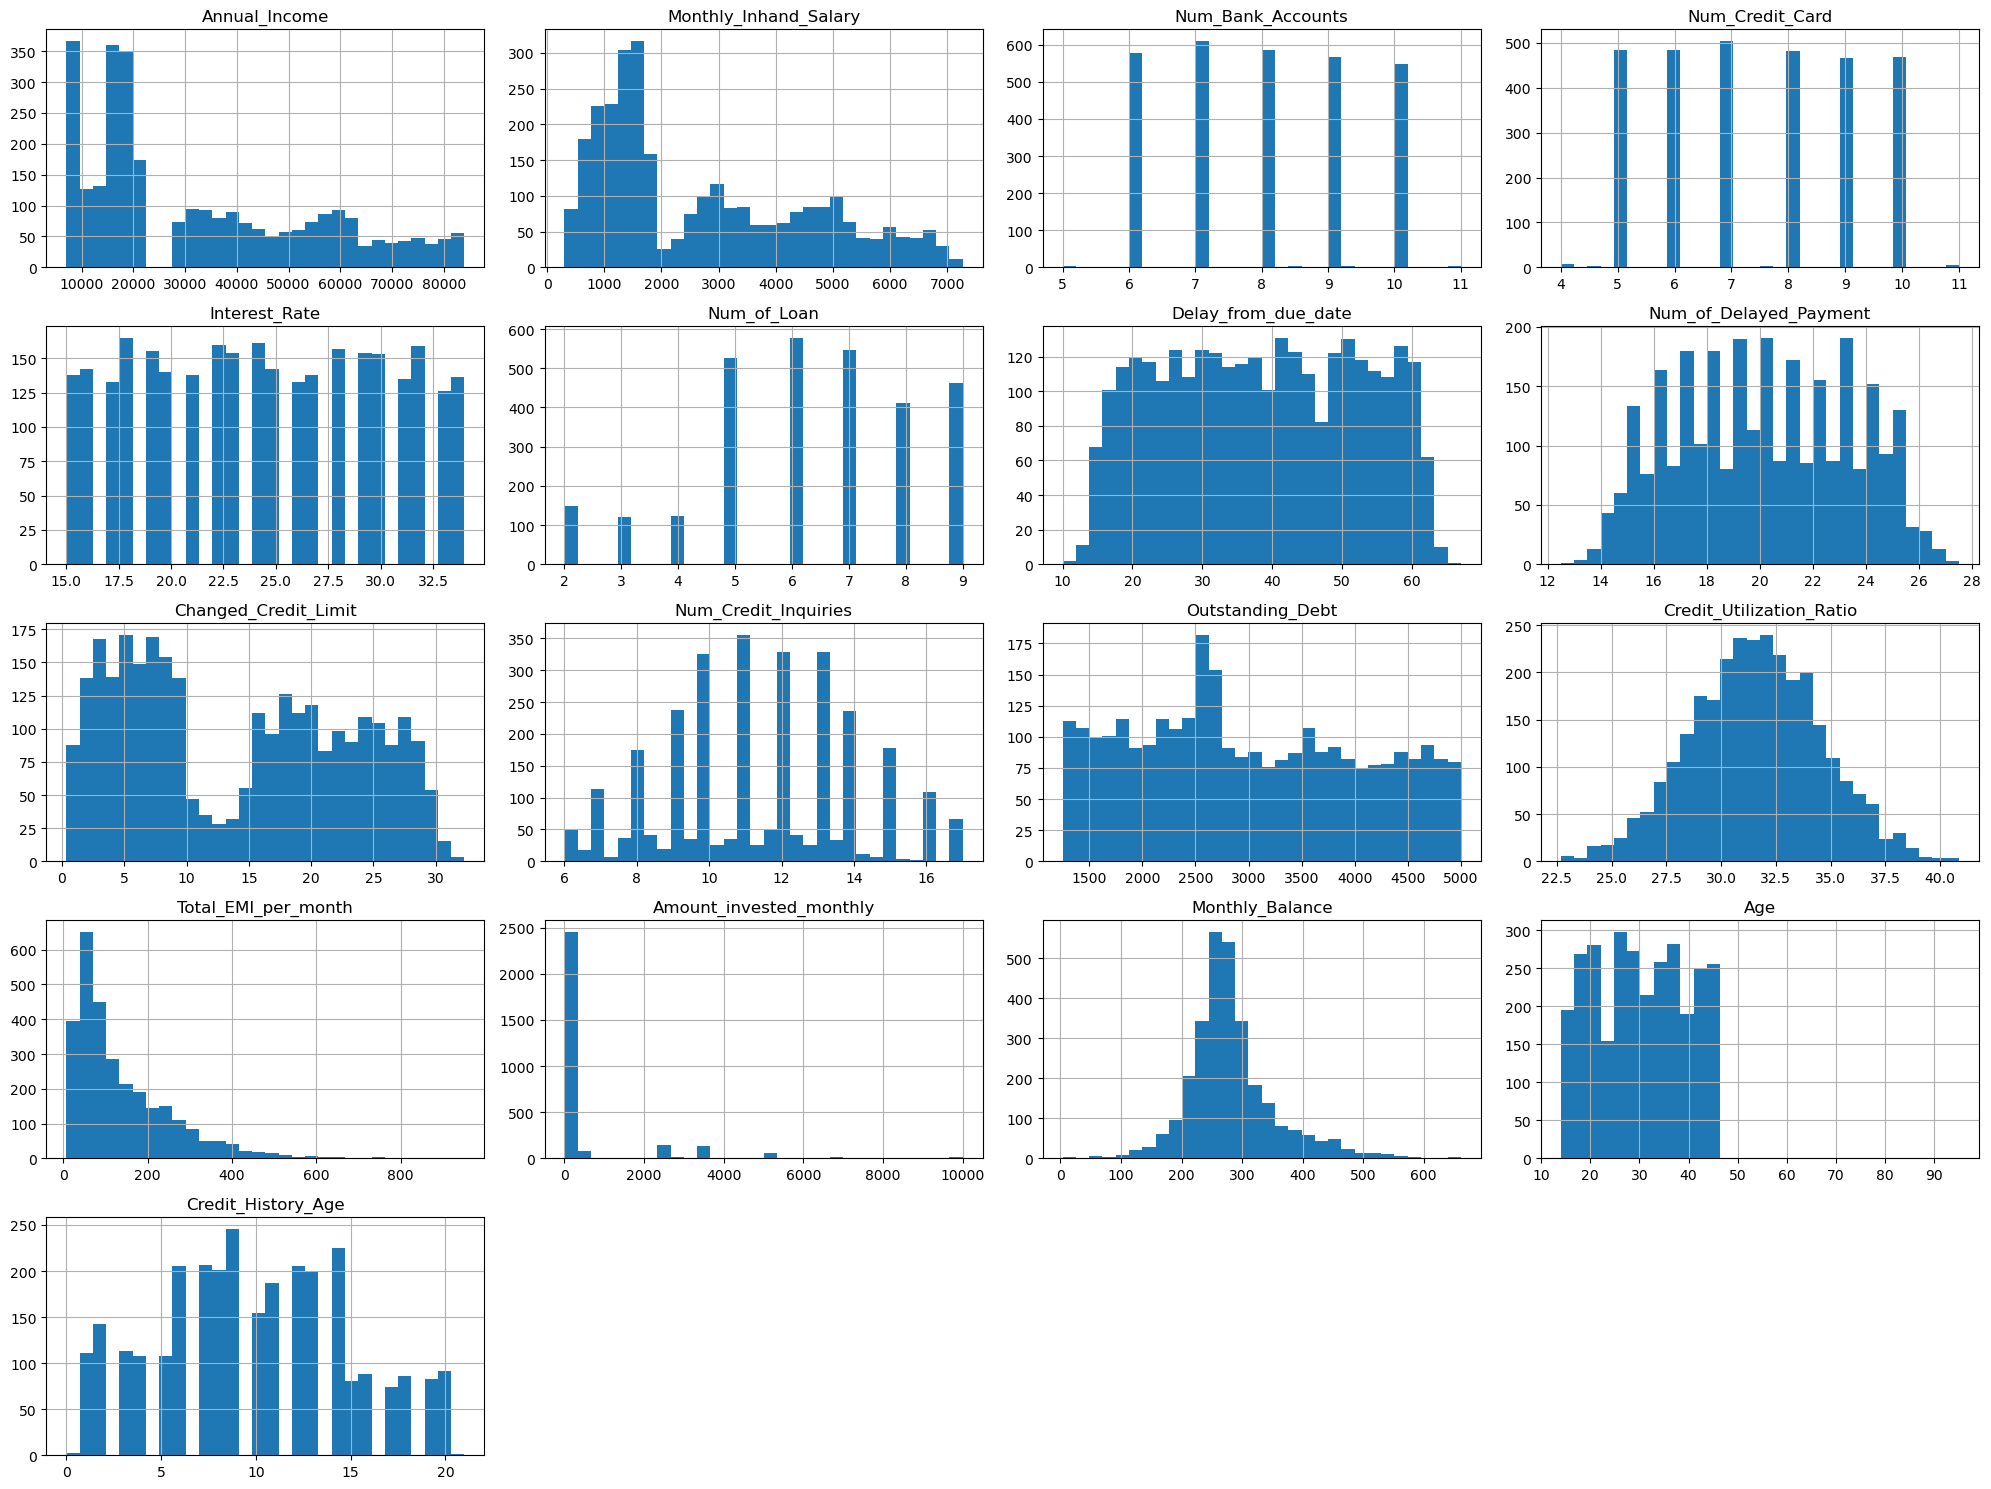

In [113]:
# 히스토그램
bad_credit_customers[continuous_vars].hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

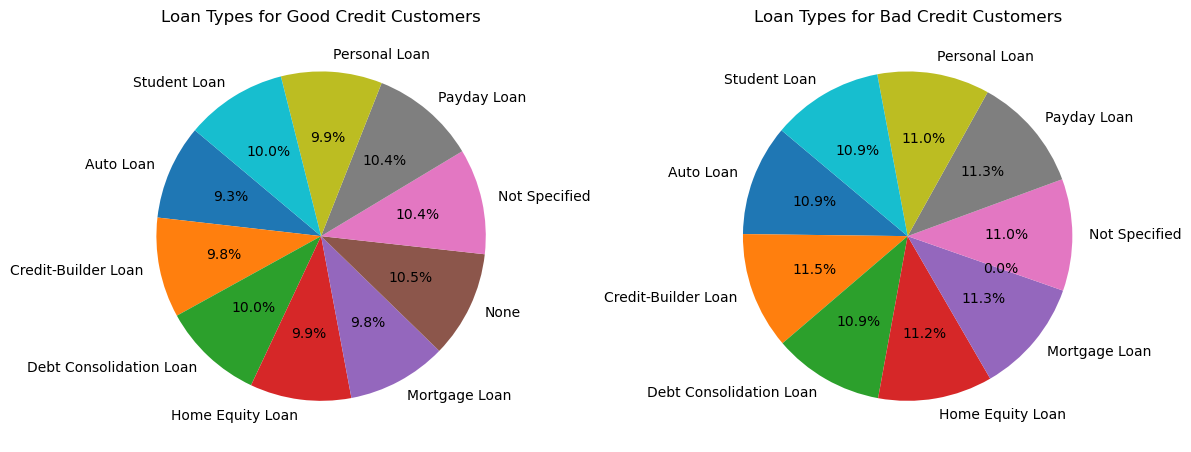

In [114]:
# 분류를 위해 필요한 라이브러리 임포트
import matplotlib.pyplot as plt

# 신용등급이 좋은 고객(Credit Mix가 'Good' 또는 'Fair')과 안 좋은 고객(Credit Mix가 'Bad') 나누기
good_credit_customers = df_grouped[df_grouped['Credit_Mix'].isin(['Good', 'Fair'])]
bad_credit_customers = df_grouped[df_grouped['Credit_Mix'] == 'Bad']

# 대출 유형 열
loan_types = [
    'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 
    'Mortgage Loan', 'None', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'
]

# 좋은 신용등급 고객들의 대출 유형 비율
good_credit_loans = good_credit_customers[loan_types].sum()

# 안 좋은 신용등급 고객들의 대출 유형 비율
bad_credit_loans = bad_credit_customers[loan_types].sum()

# 좋은 신용등급 고객들의 대출 유형 파이 플롯
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
good_credit_loans.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Loan Types for Good Credit Customers')
plt.ylabel('')

# 안 좋은 신용등급 고객들의 대출 유형 파이 플롯
plt.subplot(1, 2, 2)
bad_credit_loans.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Loan Types for Bad Credit Customers')
plt.ylabel('')

plt.tight_layout()
plt.show()


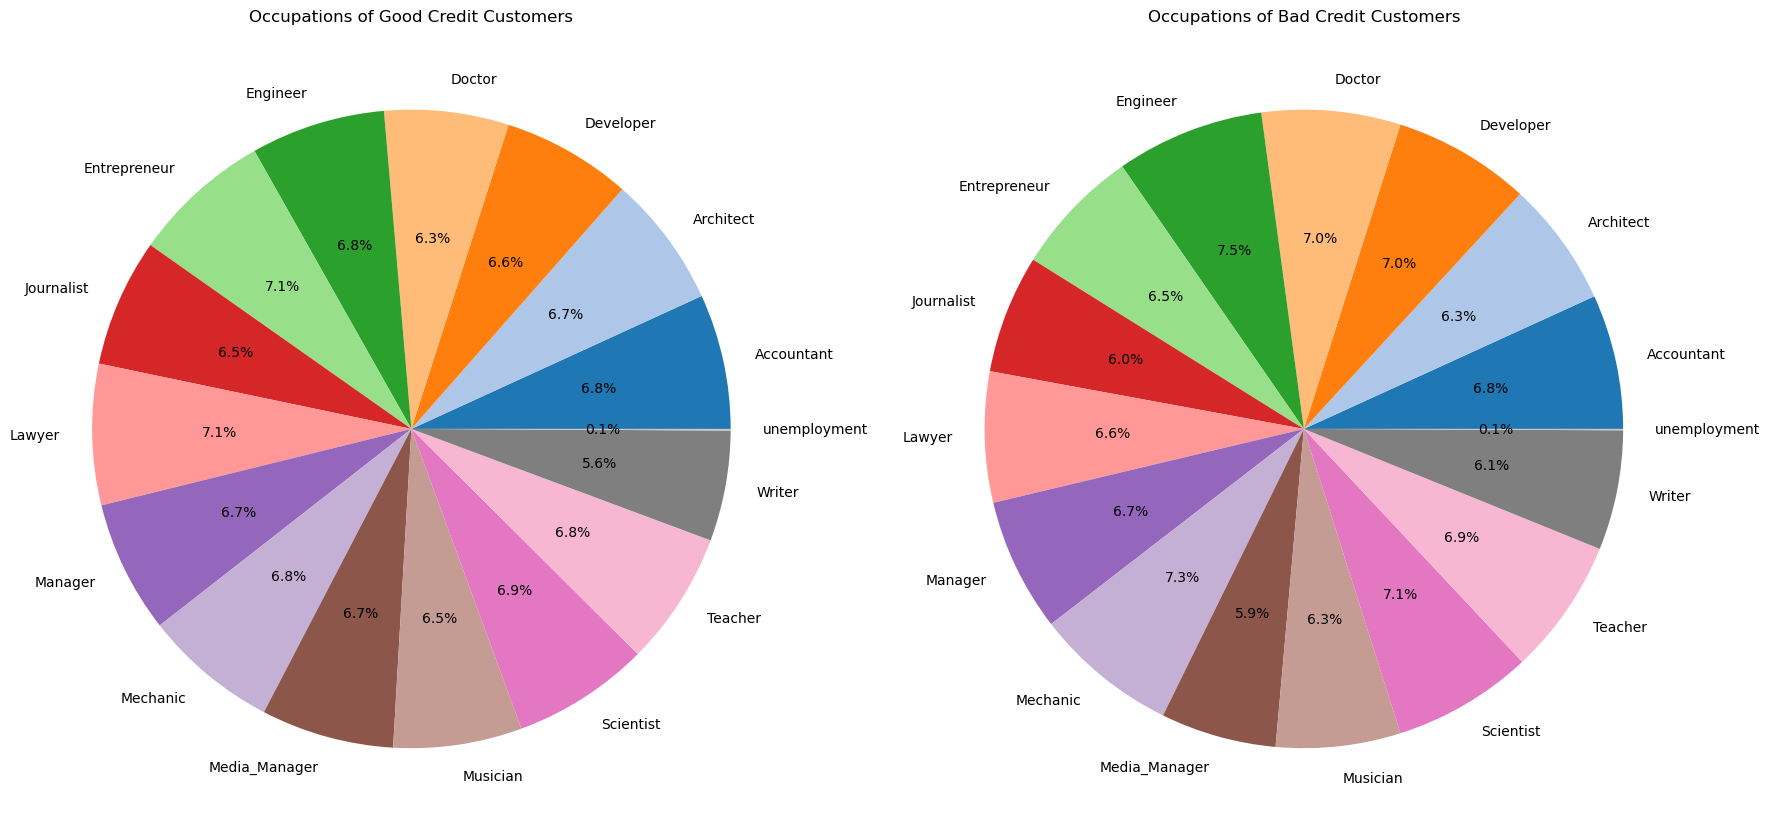

In [135]:
# 신용등급이 좋은 고객(Credit Mix가 'Good' 또는 'Fair')과 안 좋은 고객(Credit Mix가 'Bad') 나누기
good_credit_customers = df_grouped[df_grouped['Credit_Mix'].isin(['Good', 'Fair'])]
standard_credit_customers = df_grouped[df_grouped['Credit_Mix'] == 'Standard']
bad_credit_customers = df_grouped[df_grouped['Credit_Mix'] == 'Bad']

# 직업별 고객 수 계산
good_credit_occupation_counts = good_credit_customers['Occupation'].value_counts()
standard_credit_occupation_counts = standard_credit_customers['Occupation'].value_counts()
bad_credit_occupation_counts = bad_credit_customers['Occupation'].value_counts()

# 두 데이터프레임의 인덱스(직업)를 동일하게 맞추기 위해 재인덱싱
combined_index = good_credit_occupation_counts.index.union(bad_credit_occupation_counts.index)
good_credit_occupation_counts = good_credit_occupation_counts.reindex(combined_index, fill_value=0)
bad_credit_occupation_counts = bad_credit_occupation_counts.reindex(combined_index, fill_value=0)

# 파이 플롯 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# 동일한 색상을 사용하기 위해 색상 목록 생성
colors = plt.cm.tab20.colors

# 좋은 신용등급 고객들의 직업 분포 파이 플롯
axes[0].pie(good_credit_occupation_counts, labels=good_credit_occupation_counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Occupations of Good Credit Customers')

# 안 좋은 신용등급 고객들의 직업 분포 파이 플롯
axes[1].pie(bad_credit_occupation_counts, labels=bad_credit_occupation_counts.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Occupations of Bad Credit Customers')

plt.tight_layout()
plt.show()

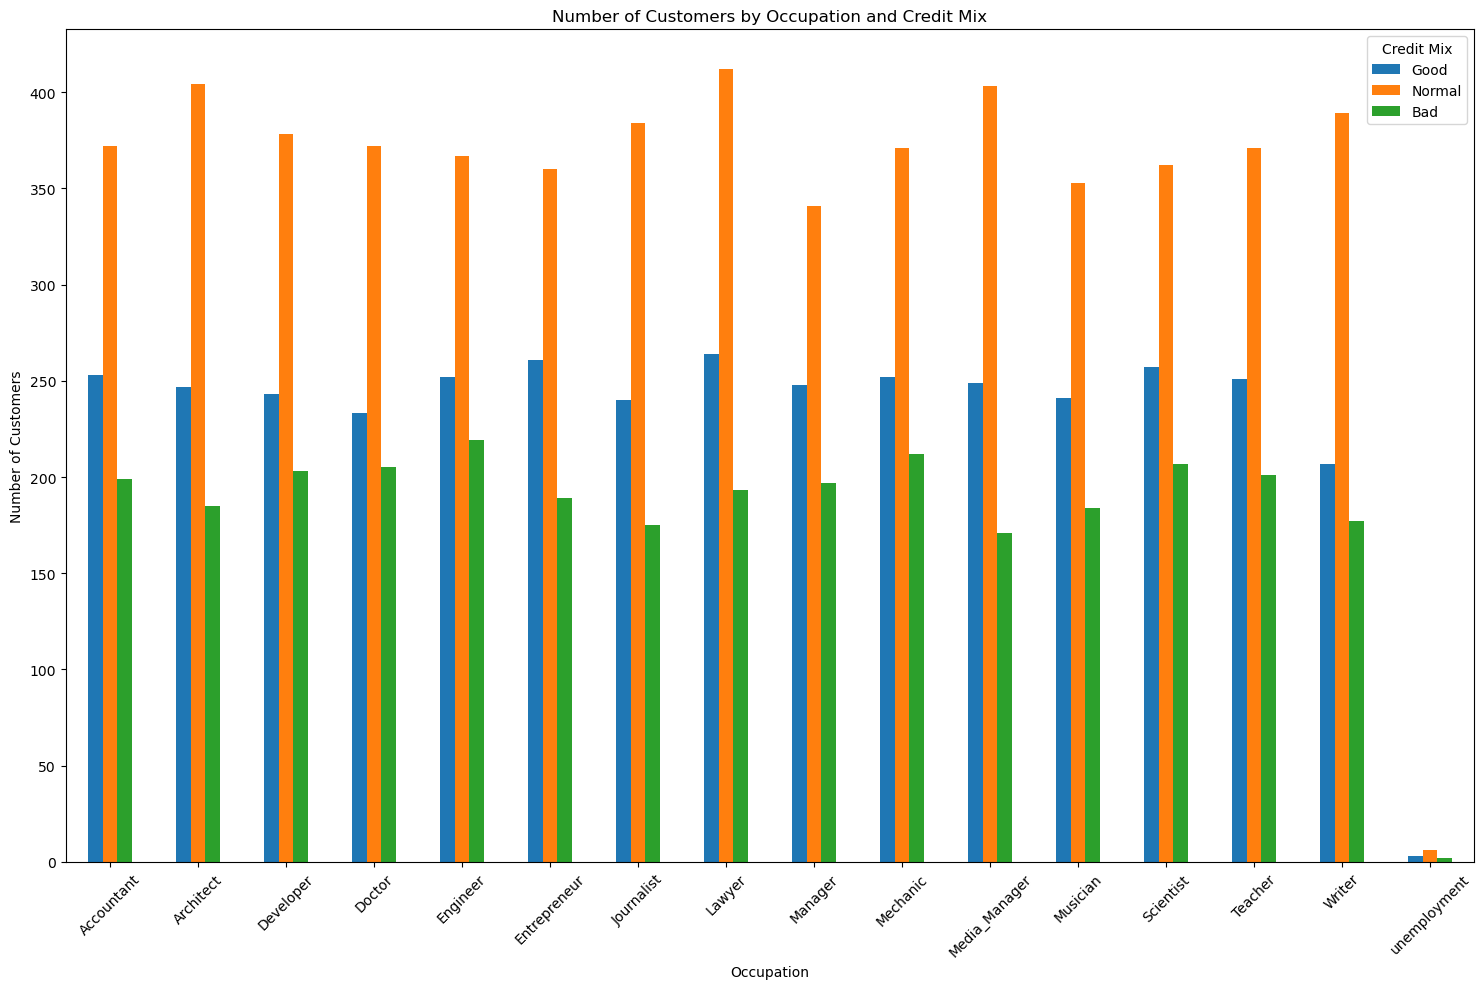

In [136]:
# 신용등급별로 고객 분류
good_credit_customers = df_grouped[df_grouped['Credit_Mix'].isin(['Good', 'Fair'])]
normal_credit_customers = df_grouped[df_grouped['Credit_Mix'] == 'Standard']
bad_credit_customers = df_grouped[df_grouped['Credit_Mix'] == 'Bad']

# 직업별 고객 수 계산
good_credit_occupation_counts = good_credit_customers['Occupation'].value_counts()
normal_credit_occupation_counts = normal_credit_customers['Occupation'].value_counts()
bad_credit_occupation_counts = bad_credit_customers['Occupation'].value_counts()

# 두 데이터프레임의 인덱스(직업)를 동일하게 맞추기 위해 재인덱싱
combined_index = good_credit_occupation_counts.index.union(normal_credit_occupation_counts.index).union(bad_credit_occupation_counts.index)
good_credit_occupation_counts = good_credit_occupation_counts.reindex(combined_index, fill_value=0)
normal_credit_occupation_counts = normal_credit_occupation_counts.reindex(combined_index, fill_value=0)
bad_credit_occupation_counts = bad_credit_occupation_counts.reindex(combined_index, fill_value=0)

# 하나의 데이터프레임으로 결합
occupation_counts_df = pd.DataFrame({
    'Good': good_credit_occupation_counts,
    'Normal': normal_credit_occupation_counts,
    'Bad': bad_credit_occupation_counts
})

# 바 차트 시각화 (카테고리 하나에 3개의 바가 나오도록)
fig, ax = plt.subplots(figsize=(15, 10))

occupation_counts_df.plot(kind='bar', ax=ax)
plt.title('Number of Customers by Occupation and Credit Mix')
plt.xlabel('Occupation')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Credit Mix')
plt.tight_layout()
plt.show()

# 관리 대상 고객 세분화

In [137]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 필요한 연속형 변수 선택
continuous_vars = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 
    'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 
    'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 
    'Monthly_Balance', 'Age', 'Credit_History_Age'
]

# 필요한 범주형 변수 선택
categorical_vars = ['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']

# 결측값 처리 (연속형 변수는 평균값으로, 범주형 변수는 최빈값으로 대체)
bad_credit_customers[continuous_vars] = bad_credit_customers[continuous_vars].fillna(bad_credit_customers[continuous_vars].mean())
bad_credit_customers[categorical_vars] = bad_credit_customers[categorical_vars].apply(lambda x: x.fillna(x.mode()[0]))

# 범주형 변수를 원-핫 인코딩
bad_credit_customers = pd.get_dummies(bad_credit_customers, columns=categorical_vars)

# 모든 변수 선택 (연속형 변수 + 원-핫 인코딩된 범주형 변수)
features = bad_credit_customers.columns.difference(['Customer_ID', 'Cluster', 'Credit_Mix'])

# 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(bad_credit_customers[features])

# 최적의 k를 찾기 위한 elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

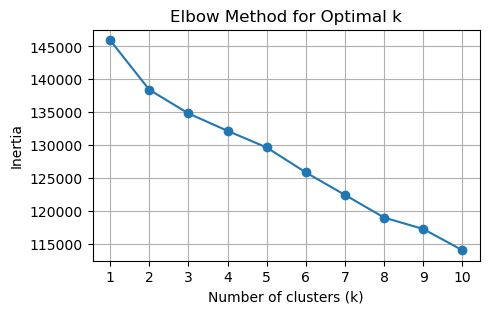

In [138]:
# Inertia 시각화
plt.figure(figsize=(5, 3))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [139]:
# 최적의 k 값으로 KMeans 클러스터링 수행 (여기서는 k=3을 가정)
kmeans = KMeans(n_clusters=4, random_state=42)
bad_credit_customers['Cluster'] = kmeans.fit_predict(scaled_features)

In [140]:
# 클러스터별 고객 수
cluster_counts = bad_credit_customers['Cluster'].value_counts().sort_index()
print("클러스터 별 고객 수 :", cluster_counts)

클러스터 별 고객 수 : Cluster
0     233
1    1102
2     877
3     707
Name: count, dtype: int64


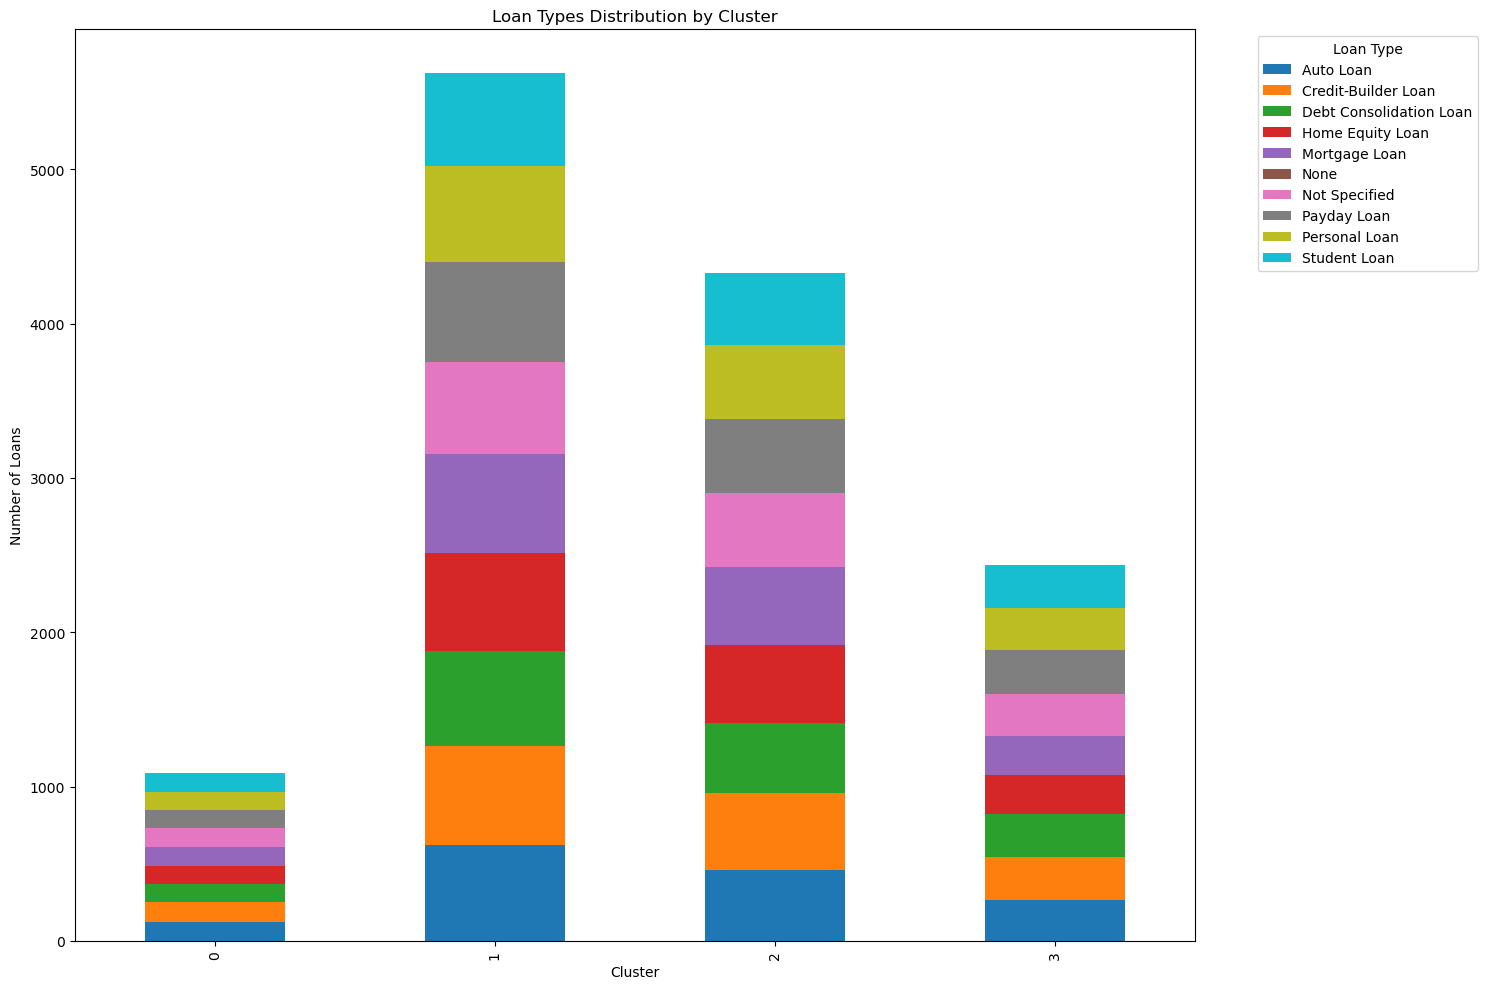

In [143]:
# 대출 유형 열
loan_types = [
    'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 
    'Mortgage Loan', 'None', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'
]

# 클러스터별 대출 유형 비율 계산
cluster_loan_distribution = bad_credit_customers.groupby('Cluster')[loan_types].sum()

# 클러스터별 대출 유형 분포 시각화
cluster_loan_distribution.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Loan Types Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Loans')
plt.legend(title='Loan Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()